# 03 · Model Training — Custom CNN, Training Loop, Metrics, and Confusion Matrix (PyTorch)

We train a custom CNN using the preprocessing from 02_preprocessing.ipynb, track metrics, and analyze results with a confusion matrix.

In [4]:
# Section 1: Setup and Imports
import os, json, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

PROJECT_ROOT = Path.cwd().parents[0]
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_DIR = DATA_RAW / 'Train'
PROC_DIR = PROJECT_ROOT / 'data' / 'processed'
STATS_PATH = PROC_DIR / 'dataset_stats.json'
SPLIT_PATH = PROC_DIR / 'split_indices.json'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# For GPU speed, allow benchmark when CUDA is present
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

print('Torch', torch.__version__, '| TorchVision', torchvision.__version__)
use_cuda = torch.cuda.is_available()
print('CUDA available:', use_cuda)
if use_cuda:
    try:
        print('CUDA runtime:', torch.version.cuda, '| Device:', torch.cuda.get_device_name(0))
    except Exception:
        pass

Torch 2.6.0+cu124 | TorchVision 0.21.0+cu124
CUDA available: True
CUDA runtime: 12.4 | Device: NVIDIA GeForce RTX 3060


In [5]:
# Section 2: Data and Transforms
with open(STATS_PATH) as f:
    ds_stats = json.load(f)
DS_MEAN, DS_STD, IMG_SIZE = ds_stats['mean'], ds_stats['std'], ds_stats['img_size']

with open(SPLIT_PATH) as f:
    split = json.load(f)
train_idx = split['train_idx']
val_idx = split['val_idx']

norm = transforms.Normalize(mean=DS_MEAN, std=DS_STD)

# Match preprocessing choices: baseline for val, medium aug for train
from torchvision import transforms

def baseline_transform(img_size=IMG_SIZE):
    return transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
    ])

from torchvision.transforms import (RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomGrayscale)

def aug_medium(img_size=IMG_SIZE):
    return transforms.Compose([
        RandomResizedCrop(img_size, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
        RandomHorizontalFlip(p=0.3),
        RandomRotation(degrees=10),
        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.03),
        RandomGrayscale(p=0.05),
        transforms.ToTensor(),
    ])

train_tf = transforms.Compose([aug_medium(IMG_SIZE), norm])
val_tf = transforms.Compose([baseline_transform(IMG_SIZE), norm])

dataset_train_all = ImageFolder(root=str(DATA_DIR), transform=train_tf)
dataset_val_all = ImageFolder(root=str(DATA_DIR), transform=val_tf)

train_ds = Subset(dataset_train_all, train_idx)
val_ds = Subset(dataset_val_all, val_idx)

BATCH_SIZE = 128
NUM_WORKERS = 2
PIN = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

n_classes = len(dataset_train_all.classes)
print('Classes:', n_classes, '| Train batches:', len(train_loader), '| Val batches:', len(val_loader))

Classes: 43 | Train batches: 246 | Val batches: 62


In [6]:
# Section 3: Custom CNN Architecture
class TrafficSignNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),  # 4x4
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256 * 4 * 4, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = TrafficSignNet(n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# AMP scaler for mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
print(model)

TrafficSignNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddin

C:\Users\PC\AppData\Local\Temp\ipykernel_18988\1100481158.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [7]:
# Section 4: Training Utilities
from collections import Counter

# Compute class weights from training indices to mitigate imbalance
all_labels = np.array([lbl for _, lbl in ImageFolder(str(DATA_DIR)).samples])
labels_train = all_labels[train_idx]
class_counts = Counter(labels_train.tolist())
weights = torch.tensor([1.0 / class_counts[c] for c in range(n_classes)], dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


def train_one_epoch(loader):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        epoch_acc += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return epoch_loss / n, epoch_acc / n


def evaluate(loader):
    model.eval()
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            epoch_loss += loss.item() * xb.size(0)
            epoch_acc += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return epoch_loss / n, epoch_acc / n

# Quick forward-pass sanity check
xb_chk, yb_chk = next(iter(train_loader))
xb_chk = xb_chk.to(device)
with torch.no_grad():
    logits_chk = model(xb_chk)
print('Sanity check logits shape:', tuple(logits_chk.shape))

Sanity check logits shape: (128, 43)


Epoch 01: train_loss=2.6459 acc=0.2214 | val_loss=1.1881 acc=0.5754
Saved new best checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt
Epoch 02: train_loss=0.9434 acc=0.6510 | val_loss=0.3339 acc=0.8763
Saved new best checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt
Epoch 02: train_loss=0.9434 acc=0.6510 | val_loss=0.3339 acc=0.8763
Saved new best checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt
Epoch 03: train_loss=0.4730 acc=0.8215 | val_loss=0.3401 acc=0.8344
Epoch 03: train_loss=0.4730 acc=0.8215 | val_loss=0.3401 acc=0.8344
Epoch 04: train_loss=0.3596 acc=0.8636 | val_loss=0.0810 acc=0.9773
Saved new best checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt
Epoch 04: train_loss=0.3596 acc=0.8636 | val_loss=0.0810 acc=0.9773
Saved new best checkpoint -> f:\VsCodeFolders\Work_Elevvo\Task_5\models\cnn_best.pt
Epoch 05: train_loss=0.2448 acc=0.9076 | val_loss=0.0857 acc=0.9552
Epoch 05: train_loss=0.2448 acc=0.90

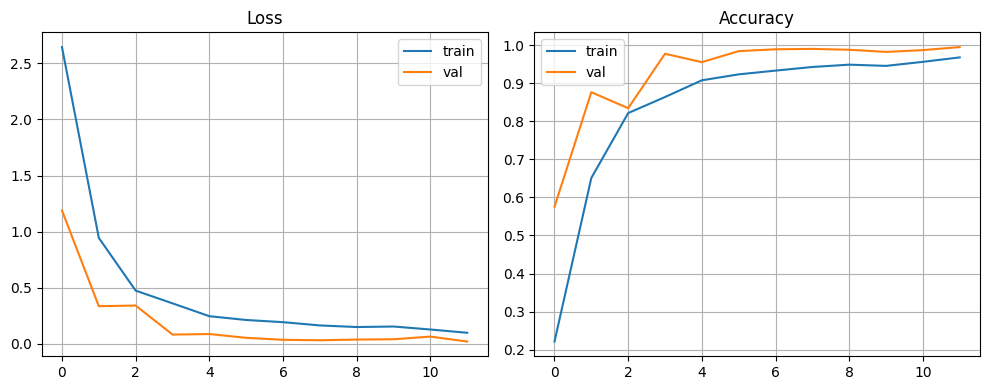

              precision    recall  f1-score   support

           0     0.9767    1.0000    0.9882        42
           1     0.9977    0.9955    0.9966       444
           2     1.0000    1.0000    1.0000       402
           3     1.0000    1.0000    1.0000       264
           4     1.0000    1.0000    1.0000       420
           5     1.0000    1.0000    1.0000       432
           6     1.0000    1.0000    1.0000       156
           7     1.0000    1.0000    1.0000       126
           8     1.0000    1.0000    1.0000        84
           9     1.0000    1.0000    1.0000       222
          10     1.0000    1.0000    1.0000       240
          11     0.8571    1.0000    0.9231        42
          12     0.9978    0.9978    0.9978       450
          13     1.0000    0.9028    0.9489        72
          14     1.0000    1.0000    1.0000        66
          15     1.0000    1.0000    1.0000        78
          16     1.0000    1.0000    1.0000       102
          17     1.0000    

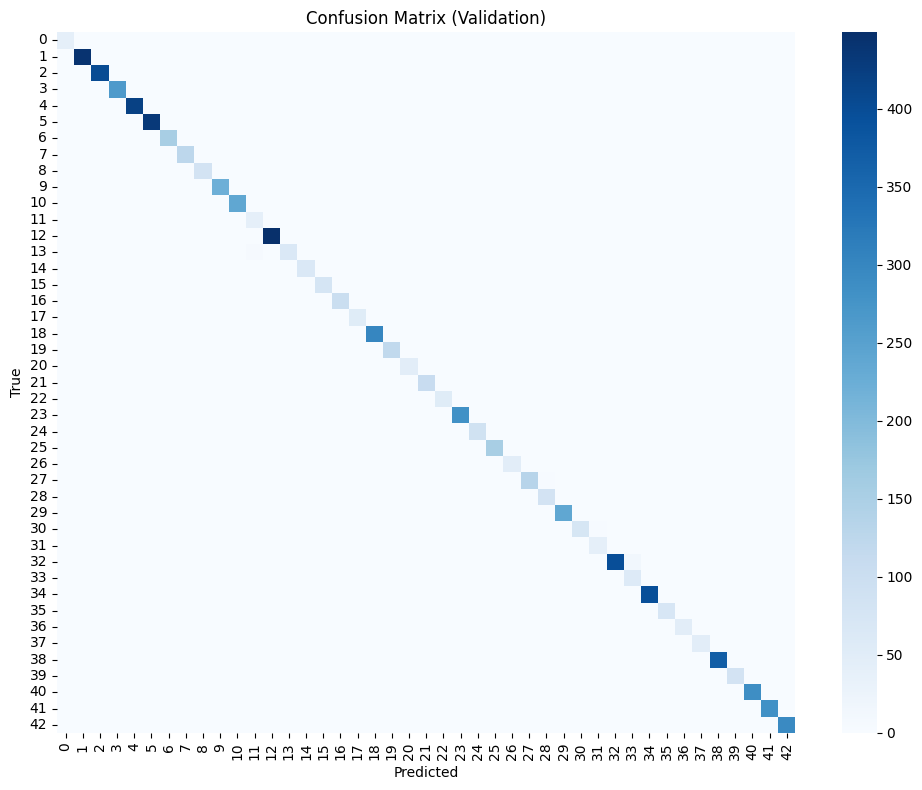

In [8]:
# Section 5: Train, Evaluate, and Analyze
EPOCHS = 12
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

ckpt_dir = PROJECT_ROOT / 'models'
ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / 'cnn_best.pt'

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(train_loader)
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step(va_acc)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f}")

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({'model_state': model.state_dict(), 'classes': dataset_train_all.classes, 'img_size': IMG_SIZE}, ckpt_path)
        print('Saved new best checkpoint ->', ckpt_path)

# Plots
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].plot(history['train_loss'], label='train')
axes[0].plot(history['val_loss'], label='val')
axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True)
axes[1].plot(history['train_acc'], label='train')
axes[1].plot(history['val_acc'], label='val')
axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True)
plt.tight_layout(); plt.show()

# Evaluation on validation set
model.load_state_dict(torch.load(ckpt_path)['model_state'])
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

print(classification_report(all_targets, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', norm=None, cbar=True)
ax.set_title('Confusion Matrix (Validation)')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout(); plt.show()

In [9]:
# Section X: Mixed-precision training loop (CUDA only; falls back to FP32 on CPU)
from torch.cuda.amp import autocast

use_cuda = torch.cuda.is_available() and (getattr(device, 'type', 'cpu') == 'cuda')
use_non_blocking = bool(use_cuda)

print(f"AMP enabled: {scaler.is_enabled() if 'scaler' in globals() else False} | non_blocking transfers: {use_non_blocking}")

best_acc = 0.0
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=use_non_blocking)
        labels = labels.to(device, non_blocking=use_non_blocking)

        optimizer.zero_grad(set_to_none=True)
        if 'scaler' in globals() and scaler.is_enabled():
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / max(total, 1)
    train_acc = correct / max(total, 1)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=use_non_blocking)
            labels = labels.to(device, non_blocking=use_non_blocking)
            if 'scaler' in globals() and scaler.is_enabled():
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / max(val_total, 1)
    val_acc = val_correct / max(val_total, 1)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    if 'scheduler' in globals() and scheduler is not None:
        try:
            scheduler.step(val_loss)
        except TypeError:
            scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

    # Save best
    if val_acc > best_acc:
        best_acc = val_acc
        os.makedirs("models", exist_ok=True)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': best_acc,
            'epoch': epoch + 1,
        }, os.path.join("models", "cnn_best.pt"))
        print(f"Saved new best model with val_acc={best_acc:.4f}")

print("Training done.")

AMP enabled: True | non_blocking transfers: True


C:\Users\PC\AppData\Local\Temp\ipykernel_18988\349045608.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\PC\AppData\Local\Temp\ipykernel_18988\349045608.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\PC\AppData\Local\Temp\ipykernel_18988\349045608.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/12] - train_loss: 0.0833 | train_acc: 0.9715 | val_loss: 0.0193 | val_acc: 0.9969
Saved new best model with val_acc=0.9969
Epoch [2/12] - train_loss: 0.0638 | train_acc: 0.9778 | val_loss: 0.0173 | val_acc: 0.9949
Epoch [2/12] - train_loss: 0.0638 | train_acc: 0.9778 | val_loss: 0.0173 | val_acc: 0.9949
Epoch [3/12] - train_loss: 0.0595 | train_acc: 0.9800 | val_loss: 0.0215 | val_acc: 0.9931
Epoch [3/12] - train_loss: 0.0595 | train_acc: 0.9800 | val_loss: 0.0215 | val_acc: 0.9931
Epoch [4/12] - train_loss: 0.0494 | train_acc: 0.9821 | val_loss: 0.0091 | val_acc: 0.9987
Saved new best model with val_acc=0.9987
Epoch [4/12] - train_loss: 0.0494 | train_acc: 0.9821 | val_loss: 0.0091 | val_acc: 0.9987
Saved new best model with val_acc=0.9987
Epoch [5/12] - train_loss: 0.0420 | train_acc: 0.9864 | val_loss: 0.0103 | val_acc: 0.9972
Epoch [5/12] - train_loss: 0.0420 | train_acc: 0.9864 | val_loss: 0.0103 | val_acc: 0.9972
Epoch [6/12] - train_loss: 0.0429 | train_acc: 0.9854 | va

In [10]:
# Quick GPU smoke test: one batch forward/backward
print('Torch:', torch.__version__, '| CUDA build:', torch.version.cuda, '| is_available:', torch.cuda.is_available())
print('Device:', device)

model.train()
images, labels = next(iter(train_loader))
images = images.to(device, non_blocking=torch.cuda.is_available())
labels = labels.to(device, non_blocking=torch.cuda.is_available())

optimizer.zero_grad(set_to_none=True)
with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
    outputs = model(images)
    loss = criterion(outputs, labels)

if scaler.is_enabled():
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
else:
    loss.backward()
    optimizer.step()

print('Smoke test OK. loss=%.4f, batch=%s, logits=%s' % (loss.item(), tuple(images.shape), tuple(outputs.shape)))

Torch: 2.6.0+cu124 | CUDA build: 12.4 | is_available: True
Device: cuda


C:\Users\PC\AppData\Local\Temp\ipykernel_18988\1986488607.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Smoke test OK. loss=0.0217, batch=(128, 3, 64, 64), logits=(128, 43)
